# 3. Model testing

In [5]:
import sys
from pathlib import Path
sys.path.append(str(Path("../../../").resolve()))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import copy
import numpy as np
import seaborn as sns
import pipeGEM as pg

from pipeGEM.analysis.tasks import TaskContainer, TASKS_FILE_PATH
from pipeGEM.data import get_syn_gene_data
from pipeGEM import load_remote_model

## Scaling test and rescaling a model

Scaling a metabolic model might not always be necessary. 
However, for some complex models with a wide range of coefficients, it is possible for some solvers to produce unstable LP solution. 
Here, we implemented some scaling methods, including arithmetic, de Buchet, geometric mean, and L1 and L2 norm scaling methods.
These approaches could help us to reduce computation time, avoid numerical error, and finding compact variables when solving LP roblems. [1]

reference: 
1. Tomlin, J. A. (1975). On scaling linear programming problems. Computational Practice in Mathematical Programming, 146–166. doi:10.1007/bfb0120718

In [21]:
ecoli = pg.Model("ecoli", load_remote_model("e_coli_core"))

In [22]:
scaling_result = ecoli.check_model_scale(method="geometric_mean")

Read LP format model from file C:\Users\user\AppData\Local\Temp\tmp8e1i_n6o.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Problematic rows (metabolite coefficients): 0
Problematic cols (metabolite coefficients): 0
Problematic rows (metabolite coefficients): 0
Problematic cols (reaction coefficients): 0


In [23]:
scaling_result

ModelScalingResult at 0x22b2e215ba0

-----------
Parameters:
{'n_iter': 10, 'method': 'GeoMeanScaler'}
-----------
Result keys:
rescaled_model, diff_A, rescaled_A, met_scaling_factor, rxn_scaling_factor

In [32]:
ecoli.reactions.get_by_id("BIOMASS_Ecoli_core_w_GAM").metabolites

{<Metabolite 3pg_c at 0x22b2e4291b0>: -1.496,
 <Metabolite accoa_c at 0x22b2e42a890>: -3.7478,
 <Metabolite atp_c at 0x22b2e42aa70>: -59.81,
 <Metabolite e4p_c at 0x22b2e42aa40>: -0.361,
 <Metabolite f6p_c at 0x22b2e428700>: -0.0709,
 <Metabolite g3p_c at 0x22b2e429e40>: -0.129,
 <Metabolite g6p_c at 0x22b2e42b9a0>: -0.205,
 <Metabolite gln__L_c at 0x22b2e429e10>: -0.2557,
 <Metabolite glu__L_c at 0x22b2e42a140>: -4.9414,
 <Metabolite h2o_c at 0x22b2e42b2e0>: -59.81,
 <Metabolite nad_c at 0x22b2e428a00>: -3.547,
 <Metabolite nadph_c at 0x22b2e428460>: -13.0279,
 <Metabolite oaa_c at 0x22b2e42a830>: -1.7867,
 <Metabolite pep_c at 0x22b2e42a1d0>: -0.5191,
 <Metabolite pyr_c at 0x22b2e428b50>: -2.8328,
 <Metabolite r5p_c at 0x22b2e42a080>: -0.8977,
 <Metabolite adp_c at 0x22b2e42bee0>: 59.81,
 <Metabolite akg_c at 0x22b2e42a5f0>: 4.1182,
 <Metabolite coa_c at 0x22b2e429630>: 3.7478,
 <Metabolite h_c at 0x22b2e42ba30>: 59.81,
 <Metabolite nadh_c at 0x22b2e42ae60>: 3.547,
 <Metabolite nadp_

In [39]:
def ratio_of_max_min_coef(model, rxn_id):
    max_coef = max([abs(c) for _, c in model.reactions.get_by_id(rxn_id).metabolites.items()])
    min_coef = min([abs(c) for _, c in model.reactions.get_by_id(rxn_id).metabolites.items()])
    return max_coef / min_coef

In [42]:
worst_ratio = max([ratio_of_max_min_coef(ecoli, r.id) for r in ecoli.reactions])

In [44]:
print(ratio_of_max_min_coef(ecoli, "BIOMASS_Ecoli_core_w_GAM"), worst_ratio)

843.5825105782792 843.5825105782792


The ratio of the maximum coef to the minimum coef is 843.6 in the biomass reaction in the original model. <br>
It is a acceptable value, but it is not a guarantee property for the other metabolic models. Let's see if the scaling method mitigate this issue.

In [33]:
scaling_result.rescaled_model.reactions.get_by_id("BIOMASS_Ecoli_core_w_GAM").metabolites

{<Metabolite 3pg_c at 0x22b2e42a500>: -0.51274063463161,
 <Metabolite accoa_c at 0x22b2e42a290>: -0.7862060767162431,
 <Metabolite atp_c at 0x22b31ed8970>: -5.389294194476442,
 <Metabolite e4p_c at 0x22b31ed8640>: -0.7731076441077104,
 <Metabolite f6p_c at 0x22b31ed8ac0>: -0.18555305461425978,
 <Metabolite g3p_c at 0x22b31ed8c10>: -0.22652497883489797,
 <Metabolite g6p_c at 0x22b31ed8c40>: -0.2643449044591689,
 <Metabolite gln__L_c at 0x22b2e65c670>: -0.2845530816746419,
 <Metabolite glu__L_c at 0x22b2e65c850>: -1.029224181089317,
 <Metabolite h2o_c at 0x22b2e40e500>: -5.389294194476442,
 <Metabolite nad_c at 0x22b2e428d60>: -0.8601152176103342,
 <Metabolite nadph_c at 0x22b2e42b9d0>: -2.1073235519126516,
 <Metabolite oaa_c at 0x22b2e429240>: -0.5440071578264254,
 <Metabolite pep_c at 0x22b2e428b80>: -0.3603049725110054,
 <Metabolite pyr_c at 0x22b2e42aec0>: -1.3759144885142385,
 <Metabolite r5p_c at 0x22b2e4293c0>: -0.7683604325856122,
 <Metabolite adp_c at 0x22b31ed88e0>: 5.389294194

In [45]:
worst_ratio = max([ratio_of_max_min_coef(scaling_result.rescaled_model, r.id) for r in ecoli.reactions])
print(ratio_of_max_min_coef(scaling_result.rescaled_model, "BIOMASS_Ecoli_core_w_GAM"), worst_ratio)

29.044491914617467 29.044491914617467


Now the coefficient scales are in a better range of values. <br>The only disavantage of this method is that the rescaled models could have chaotic coefficients and different scales of metabolites and constraints.<br> Most of the algorithms in PipeGEM could take the rescaling factors into account. <br> It is also possible to reverse the scaling effect using model.undo_scaling(rxn_scaling_factor, met_scaling_factor, n_digits).

## Consistency test

In [10]:
ecoli = pg.Model("ecoli", load_remote_model("e_coli_core"))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-28


In [13]:
fastcc_result = ecoli.check_consistency(method = "FASTCC", tol=1e-6)

Flux tolerance used: 1e-06
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmp3db6j_l9.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Found and flipped 1 reactions
Inconsistent irreversible rxns: 9
Inconsistent irreversible rxns (2nd run): 8


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 859.37it/s]


In [17]:
fastcc_result

FastCCAnalysis at 0x22b318ee800

-----------
Parameters:
{'is_convex': True, 'tol': 1e-06}
-----------
Result keys:
consistent_model, removed_rxn_ids, kept_rxn_ids, flux_record
-----------
Running time: 
 0.27443766593933105

In [14]:
# check ids of the removed rxns

fastcc_result.removed_rxn_ids

array(['EX_fru_e', 'EX_fum_e', 'EX_gln__L_e', 'EX_mal__L_e', 'FRUpts2',
       'FUMt2_2', 'GLNabc', 'MALt2_2'], dtype='<U24')

In [18]:
# to confirm they are inconsistent

for r in fastcc_result.removed_rxn_ids:
    with ecoli as model:
        model.reactions.get_by_id(r).lower_bound = 1e-6
        print(model.optimize())

<Solution infeasible at 0x22b2e445a50>
<Solution infeasible at 0x22b2e446980>
<Solution infeasible at 0x22b2e445660>
<Solution infeasible at 0x22b2e444790>
<Solution infeasible at 0x22b2e447cd0>
<Solution infeasible at 0x22b2e447fd0>
<Solution infeasible at 0x22b2e4474f0>
<Solution infeasible at 0x22b2e444c10>


C:\Users\user\mambaforge\envs\cobra310\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\user\mambaforge\envs\cobra310\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\user\mambaforge\envs\cobra310\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\user\mambaforge\envs\cobra310\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\user\mambaforge\envs\cobra310\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\user\mambaforge\envs\cobra310\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solv

## Functionality testing with metabolic tasks

A Metabolc task were first defined in Thiele and coworkers (2013):

*“metabolic task as a nonzero flux through a reaction or through a pathway leading to the production of a metabolite B from a metabolite A. The metabolic capacity of the network was demonstrated by testing nonzero flux values for these metabolic tasks. For each of the simulations, a steady-state flux distribution was calculated. Each metabolic task was optimized individually by choosing the corresponding reaction in the model, if present, as objective function and maximized the flux through the reaction”.*

A task-protection method was then proposed in ([Anne Richelle et al. 2019](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006867)). Based on this study, we implemented its method in PipeGEM and tried to make it more flexible.



## Load existing task file

In [3]:
tasks = TaskContainer.load(TASKS_FILE_PATH)

In [4]:
for i, (task_id, task) in enumerate(tasks.items()):
    if i == 3:
        break
    print(f"Task ID: {task_id}", '\n', task)

Task ID: 1.0 
 system : ENERGY METABOLISM
subsystem : OXYDATIVE PHOSPHORYLATION
description : Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I)
should fail : False
----- input metabolites -----

---------------------------------------
|     Met ID|      LB|      UB|   comp|
---------------------------------------
|   MAM03103|   1.000|   1.000|      m|
|   MAM02553|   1.000|   1.000|      m|
|   MAM02039|   5.000|   5.000|      m|
---------------------------------------

----- output metabolites -----

---------------------------------------
|     Met ID|      LB|      UB|   comp|
---------------------------------------
|   MAM03102|   1.000|   1.000|      m|
|   MAM02552|   1.000|   1.000|      m|
|   MAM02039|   4.000|   4.000|      i|
---------------------------------------

Task ID: 2.0 
 system : ENERGY METABOLISM
subsystem : OXYDATIVE PHOSPHORYLATION
description : Oxidative phosphorylation via succinate-coenzyme Q oxidoreductase (COMPLEX II)
should fail : F

## Manipulating a task

In [5]:
print(tasks["1.0"])

system : ENERGY METABOLISM
subsystem : OXYDATIVE PHOSPHORYLATION
description : Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I)
should fail : False
----- input metabolites -----

---------------------------------------
|     Met ID|      LB|      UB|   comp|
---------------------------------------
|   MAM03103|   1.000|   1.000|      m|
|   MAM02553|   1.000|   1.000|      m|
|   MAM02039|   5.000|   5.000|      m|
---------------------------------------

----- output metabolites -----

---------------------------------------
|     Met ID|      LB|      UB|   comp|
---------------------------------------
|   MAM03102|   1.000|   1.000|      m|
|   MAM02552|   1.000|   1.000|      m|
|   MAM02039|   4.000|   4.000|      i|
---------------------------------------



In [7]:
new_task = copy.deepcopy(tasks["1.0"])

In [8]:
new_task.in_mets, new_task.out_mets

([{'met_id': 'MAM03103', 'lb': 1.0, 'ub': 1.0, 'compartment': 'm'},
  {'met_id': 'MAM02553', 'lb': 1.0, 'ub': 1.0, 'compartment': 'm'},
  {'met_id': 'MAM02039', 'lb': 5.0, 'ub': 5.0, 'compartment': 'm'}],
 [{'met_id': 'MAM03102', 'lb': 1.0, 'ub': 1.0, 'compartment': 'm'},
  {'met_id': 'MAM02552', 'lb': 1.0, 'ub': 1.0, 'compartment': 'm'},
  {'met_id': 'MAM02039', 'lb': 4.0, 'ub': 4.0, 'compartment': 'i'}])

In [9]:
new_task.in_mets.append({"met_id": 'glc_D', 'lb': 0, 'ub': 10, 'compartment': 'c'})
new_task.out_mets.append({"met_id": 'co2', 'lb': 0, 'ub': 10, 'compartment': 'c'})
print(new_task)

system : ENERGY METABOLISM
subsystem : OXYDATIVE PHOSPHORYLATION
description : Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I)
should fail : False
----- input metabolites -----

----------------------------------------
|     Met ID|      LB|       UB|   comp|
----------------------------------------
|   MAM03103|   1.000|    1.000|      m|
|   MAM02553|   1.000|    1.000|      m|
|   MAM02039|   5.000|    5.000|      m|
|      glc_D|   0.000|   10.000|      c|
----------------------------------------

----- output metabolites -----

----------------------------------------
|     Met ID|      LB|       UB|   comp|
----------------------------------------
|   MAM03102|   1.000|    1.000|      m|
|   MAM02552|   1.000|    1.000|      m|
|   MAM02039|   4.000|    4.000|      i|
|        co2|   0.000|   10.000|      c|
----------------------------------------



In [11]:
# add to a task container
new_tasks = TaskContainer()
new_tasks["1"] = new_task

# you can use it to do the following task testing

## Test the loaded tasks

In [12]:
from pipeGEM import load_remote_model
from pipeGEM.data import GeneData

In [13]:
human1 = pg.Model("human", 
                  load_remote_model("Human-GEM"))

  0%|          | 0/792653 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-28


In [14]:
human1.add_tasks("general",  # the name of your task
                 tasks)  # TaskContainer containing the tasks

In [15]:
data = np.log2(get_syn_gene_data(human1, n_sample=3) + 1)

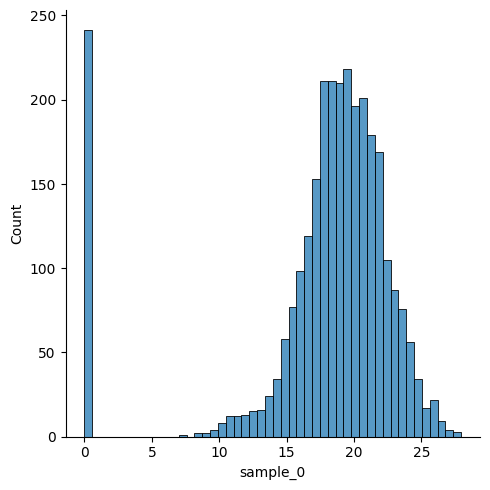

In [16]:
sns.displot(data["sample_0"])

In [17]:
data.head()

,sample_0,sample_1,sample_2
ENSG00000000419,17.216367,0.000000,17.690939
ENSG00000001036,17.261186,18.372886,17.084974
ENSG00000001084,17.312174,19.877621,20.669270
ENSG00000001630,19.128405,20.176900,17.418964
ENSG00000002549,0.000000,0.000000,0.000000


In [18]:
gene_data = GeneData(data=data["sample_0"], 
                     data_transform=lambda x: np.log2(x), 
                     absent_expression=0)
p90_threshold = gene_data.get_threshold("percentile", p=90)

human1.add_tasks("general", tasks)
human1.add_gene_data("sample_0", gene_data)

C:\Users\user\AppData\Local\Temp\ipykernel_80808\2703284718.py:2: RuntimeWarning: divide by zero encountered in log2
  data_transform=lambda x: np.log2(x),
100%|██████████████████████████████████████████████████████████████████████████| 13073/13073 [00:01<00:00, 8703.83it/s]

Finished mapping in 1.5551297664642334 seconds.


In [37]:
trunc_tasks = tasks.subset(["3.0", "5.0", "9.0"])

In [38]:
human1.add_tasks("reduc", trunc_tasks)

In [40]:
task_analysis_result = human1.test_tasks("reduc", 
                                         model_compartment_parenthesis="{}",
                                         n_additional_path=3)

score of the model: 3 / 3


In [47]:
task_analysis_result.result_df["rxn_supps"]["9.0"]

['MAR04388',
 'MAR04358',
 'MAR04363',
 'MAR04365',
 'MAR04368',
 'MAR04373',
 'MAR04375',
 'MAR04391',
 'MAR04394',
 'MAR08583',
 'MAR04052',
 'MAR04350',
 'MAR04352',
 'MAR04354',
 'MAR04474',
 'MAR04841',
 'MAR04038',
 'MAR04406',
 'MAR04799',
 'MAR04802',
 'MAR04804',
 'MAR04808',
 'MAR04810',
 'MAR04812',
 'MAR04814',
 'MAR04006',
 'MAR03970',
 'MAR04008',
 'MAR04345',
 'MAR04579',
 'MAR04806',
 'MAR03802',
 'MAR03829',
 'MAR03862',
 'MAR03806',
 'MAR03807',
 'MAR04658',
 'MAR06707',
 'MAR00710',
 'MAR04139',
 'MAR04408',
 'MAR06914',
 'MAR06916',
 'MAR06918',
 'MAR06921',
 'MAR03960',
 'MAR03980',
 'MAR01838',
 'MAR01844',
 'MAR03929',
 'MAR03972',
 'MAR04338',
 'MAR04440',
 'MAR04503',
 'MAR04505',
 'MAR05127',
 'MAR03959',
 'MAR04896',
 'MAR04947',
 'MAR04990',
 'MAR05002',
 'MAR05023',
 'MAR05029',
 'MAR05035',
 'MAR05310',
 'MAR05436',
 'MAR05839',
 'MAR05998',
 'MAR06023',
 'MAR06380',
 'MAR09188',
 'MAR03825',
 'MAR03950',
 'MAR04888',
 'MAR04898',
 'MAR05043',
 'MAR05096',

In [54]:
from functools import reduce

In [60]:
reduce(set.union, [set(i) for i in task_analysis_result.result_df["task_support_rxns"]["9.0"]])

{'MAR00045',
 'MAR00061',
 'MAR00097',
 'MAR00156',
 'MAR00157',
 'MAR00158',
 'MAR00159',
 'MAR00161',
 'MAR00162',
 'MAR00163',
 'MAR00175',
 'MAR00229',
 'MAR00710',
 'MAR00742',
 'MAR01095',
 'MAR01231',
 'MAR01232',
 'MAR01263',
 'MAR01264',
 'MAR01267',
 'MAR01268',
 'MAR01280',
 'MAR01281',
 'MAR01283',
 'MAR01284',
 'MAR01285',
 'MAR01315',
 'MAR01316',
 'MAR01461',
 'MAR01485',
 'MAR01578',
 'MAR01581',
 'MAR01584',
 'MAR01608',
 'MAR01611',
 'MAR01621',
 'MAR01623',
 'MAR01672',
 'MAR01673',
 'MAR01676',
 'MAR01679',
 'MAR01772',
 'MAR01779',
 'MAR01785',
 'MAR01824',
 'MAR01996',
 'MAR01998',
 'MAR02225',
 'MAR02352',
 'MAR02358',
 'MAR02416',
 'MAR02730',
 'MAR02759',
 'MAR02869',
 'MAR02870',
 'MAR02881',
 'MAR02895',
 'MAR02896',
 'MAR02897',
 'MAR03032',
 'MAR03209',
 'MAR03214',
 'MAR03259',
 'MAR03437',
 'MAR03438',
 'MAR03478',
 'MAR03480',
 'MAR03481',
 'MAR03482',
 'MAR03746',
 'MAR03804',
 'MAR03839',
 'MAR03841',
 'MAR03843',
 'MAR03845',
 'MAR03846',
 'MAR03874',

In [61]:
task_analysis_result.is_essential(task_id="9.0", rxn_id='MAR00045')

False

In [53]:
task_analysis_result.result_df

,Passed,Should fail,Missing mets,Status,Obj_value,Obj_rxns,task_support_rxns,task_support_rxn_fluxes,Sink Status,rxn_supps
3.0,True,False,False,optimal,10.0,"[output_MAM01261m: MAM01261m --> , output_MAM0...","[[MAR06412, MAR06409, MAR08746, MAR20069]]","[{'MAR06412': 1.0, 'MAR06409': -1.0, 'MAR08746...",optimal,"[MAR06412, MAR08514, MAR04280, MAR04461, MAR03..."
5.0,True,False,False,optimal,421.0,"[output_MAM01371c: MAM01371c --> , output_MAM0...","[[MAR04388, MAR04301, MAR04358, MAR04363, MAR0...","[{'MAR04388': 2.0, 'MAR04301': 1.0, 'MAR04358'...",optimal,"[MAR04388, MAR04301, MAR04358, MAR04363, MAR04..."
9.0,True,False,False,optimal,62.333333,"[output_MAM02167c: MAM02167c --> , output_MAM0...","[[MAR04394, MAR04052, MAR04352, MAR04474, MAR0...","[{'MAR04394': 1.0, 'MAR04052': 1.0, 'MAR04352'...",optimal,"[MAR04388, MAR04358, MAR04363, MAR04365, MAR04..."


In [27]:
# saving the result as a json file
task_analysis_result.save("./task_result.json")

## Get activated tasks and supported reactions

In [22]:
activated_tasks = human1.get_activated_tasks("sample_0", task_analysis_result, score_threshold=p90_threshold.exp_th)
activated_task_sup_rxns = human1.get_activated_task_sup_rxns("sample_0", task_analysis_result, score_threshold=p90_threshold.exp_th)

C:\Users\user\AppData\Local\Temp\ipykernel_80808\2703284718.py:2: RuntimeWarning: divide by zero encountered in log2
  data_transform=lambda x: np.log2(x),


In [36]:
human1.gene_data["sample_0"].rxn_scores["MAR01353"]

C:\Users\user\AppData\Local\Temp\ipykernel_80808\2703284718.py:2: RuntimeWarning: divide by zero encountered in log2
  data_transform=lambda x: np.log2(x),


4.581270167620947

In [30]:
human1.calc_ind_task_score(data_name="sample_0", task_analysis=task_analysis_result)

C:\Users\user\AppData\Local\Temp\ipykernel_80808\2703284718.py:2: RuntimeWarning: divide by zero encountered in log2
  data_transform=lambda x: np.log2(x),


{'1.0': -1,
 '2.0': -1,
 '3.0': -1,
 '4.0': -1,
 '5.0': -1,
 '6.0': -1,
 '7.0': -1,
 '8.0': -1,
 '9.0': -1,
 '10.0': -1,
 '11.0': -1,
 '12.0': -1,
 '13.0': -1,
 '14.0': -1,
 '15.0': -1,
 '16.0': -1,
 '17.0': -1,
 '18.0': -1,
 '19.0': -1,
 '20.0': -1,
 '21.0': -1,
 '22.0': -1,
 '23.0': -1,
 '24.0': -1,
 '25.0': -1,
 '26.0': -1,
 '27.0': -1,
 '28.0': -1,
 '29.0': -1,
 '30.0': -1,
 '31.0': -1,
 '32.0': -1,
 '33.0': -1,
 '34.0': -1,
 '35.0': -1,
 '36.0': -1,
 '37.0': -1,
 '38.0': -1,
 '39.0': -1,
 '40.0': -1,
 '41.0': -1,
 '42.0': -1,
 '43.0': -1,
 '44.0': -1,
 '45.0': -1,
 '46.0': -1,
 '47.0': -1,
 '48.0': -1,
 '49.0': -1,
 '50.0': -1,
 '51.0': -1,
 '52.0': -1,
 '53.0': -1,
 '54.0': -1,
 '55.0': -1,
 '56.0': -1,
 '57.0': -1,
 '58.0': -1,
 '59.0': -1,
 '60.0': -1,
 '61.0': -1,
 '62.0': -1,
 '63.0': -1,
 '64.0': -1,
 '65.0': -1,
 '66.0': -1,
 '67.0': -1,
 '68.0': -1,
 '69.0': -1,
 '70.0': -1,
 '71.0': -1,
 '72.0': -1,
 '73.0': -1,
 '74.0': -1,
 '75.0': -1,
 '76.0': -1,
 '77.0': -1,
 '78.0':

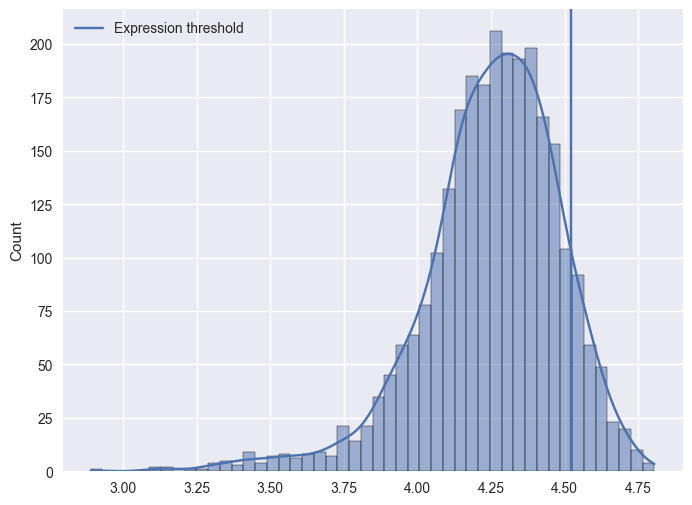

In [28]:
p90_threshold.plot()

In [26]:
activated_tasks

['1.0',
 '2.0',
 '3.0',
 '4.0',
 '5.0',
 '6.0',
 '7.0',
 '8.0',
 '9.0',
 '10.0',
 '11.0',
 '12.0',
 '13.0',
 '14.0',
 '15.0',
 '16.0',
 '17.0',
 '18.0',
 '19.0',
 '20.0',
 '21.0',
 '22.0',
 '23.0',
 '24.0',
 '25.0',
 '26.0',
 '27.0',
 '28.0',
 '29.0',
 '30.0',
 '31.0',
 '32.0',
 '33.0',
 '34.0',
 '35.0',
 '36.0',
 '37.0',
 '38.0',
 '39.0',
 '40.0',
 '41.0',
 '42.0',
 '43.0',
 '44.0',
 '45.0',
 '46.0',
 '47.0',
 '48.0',
 '49.0',
 '50.0',
 '51.0',
 '52.0',
 '53.0',
 '54.0',
 '55.0',
 '56.0',
 '57.0',
 '58.0',
 '59.0',
 '60.0',
 '61.0',
 '62.0',
 '63.0',
 '64.0',
 '65.0',
 '66.0',
 '67.0',
 '68.0',
 '69.0',
 '70.0',
 '71.0',
 '72.0',
 '73.0',
 '74.0',
 '75.0',
 '76.0',
 '77.0',
 '78.0',
 '79.0',
 '80.0',
 '81.0',
 '82.0',
 '83.0',
 '84.0',
 '85.0',
 '86.0',
 '87.0',
 '88.0',
 '89.0',
 '90.0',
 '91.0',
 '92.0',
 '93.0',
 '94.0',
 '95.0',
 '96.0',
 '97.0',
 '98.0',
 '99.0',
 '100.0',
 '101.0',
 '102.0',
 '103.0',
 '104.0',
 '105.0',
 '106.0',
 '107.0',
 '108.0',
 '109.0',
 '110.0',
 '111.0'

In [24]:
activated_task_sup_rxns[:10]

['MAR11246',
 'MAR02286',
 'MAR06245',
 'MAR05954',
 'MAR02358',
 'MAR10367',
 'MAR04862',
 'MAR02520',
 'MAR07685',
 'MAR10500']